# packages and dependencies


In [ ]:
#preferred to use colab to avoid some problems  related to models installation
"""
!pip install nltk
!pip install spacy
!pip install tensorflow
!pip install keras
"""

!python -m spacy download nb_core_news_sm 
!spacy download nb_core_news_sm 

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import string
import re
import nltk
nltk.download('punkt')
import json
import spacy
from spacy.lang.nb.examples import sentences
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,Activation,InputLayer,Dropout
from keras.models import Sequential

import pickle

     |████████████████████████████████| 14.2 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('nb_core_news_sm')
     |████████████████████████████████| 14.2 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('nb_core_news_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# preparing data

In [ ]:
#reading data

file=open(r'intents_test.json', encoding='utf-8')
f=file.read()
file.close()
obj=json.loads(f)


In [ ]:
#helping functions

def tokenize(sent):
  #return list of tokenized words
  return nltk.word_tokenize(sent)
 

def lemmatize(doc):  

  
    no_lemmatizer = spacy.load("nb_core_news_sm") #Norwegian lemmatizer

    p_marks=string.punctuation

    prons=["jeg","du","mitt","ditt","min","din","meg","deg"]
    
    lemmas = [] #the base form of the words
    for w in doc:
      if w in prons:
          lemmas.append(w)
      elif w.strip() not in p_marks:
        lemma = w if w.lower() in prons else w.lower()
        lemma=re.sub("[0-9]+", "",w)
        lemma=(no_lemmatizer(w)[0].lemma_).lower()
        lemmas.append(lemma)
    #print(lemmas)
    return lemmas

def bag_of_words(sentence, uniq_words): 
        
    wrds = lemmatize(sentence)   
    bag = [1 if w in wrds else  0 for w in  uniq_words]
    return bag


In [ ]:
#prepare data for training

X_res,y_res=[],[] #textual values
uniq_words=[] #vocabulary or lemmas

for intent in obj["intents"]:

    for pattern in intent["patterns"]:
        wrds = tokenize(pattern)
        uniq_words.extend(wrds)
        X_res.append(wrds)
        y_res.append(intent["tag"])
        
#lemmatizing        

uniq_words = lemmatize(uniq_words)
uniq_words = sorted(list(set(uniq_words)))


In [ ]:
#convert textual traning data to numeric values

X_train,y_train=[],[] 
#bags of words
for pattern in X_res:
    bag=bag_of_words( pattern, uniq_words)
    X_train.append(bag)

classes=sorted(list(set(y_res)))

for i, x in enumerate(X_res):
        y_row= [0 for _ in range(len(classes))]
        
        y_row[classes.index(y_res[i])] = 1
        
        y_train.append(y_row)


X_train = np.array(X_train)
y_train = np.array(y_train)


In [ ]:
#y_train

# Network building 

In [ ]:
#Network  architecture 


nn = tf.keras.models.Sequential() 
nn.add( InputLayer(input_shape=[None, len(X_train[0])] ) )
nn.add(tf.keras.layers.Dense(15,activation='relu') )
nn.add(tf.keras.layers.Dense(len(classes),activation='softmax')) 
nn.compile(loss='categorical_crossentropy',optimizer="adam", metrics=["accuracy"])
fitting_stage=nn.fit( X_train, y_train, epochs=400)


#save the model
with open("nn.pickle", "wb") as f:
    pickle.dump(nn, f)

pic = open("nn.pickle", "rb")
nn = pickle.load(pic)


Epoch 1/400
2/2 [==============================] - 1s 8ms/step - loss: 2.7698 - accuracy: 0.0000e+00
Epoch 2/400
2/2 [==============================] - 0s 6ms/step - loss: 2.7610 - accuracy: 0.0000e+00
Epoch 3/400
2/2 [==============================] - 0s 9ms/step - loss: 2.7527 - accuracy: 0.0000e+00
Epoch 4/400
2/2 [==============================] - 0s 8ms/step - loss: 2.7447 - accuracy: 0.0000e+00
Epoch 5/400
2/2 [==============================] - 0s 7ms/step - loss: 2.7367 - accuracy: 0.0185
Epoch 6/400
2/2 [==============================] - 0s 7ms/step - loss: 2.7288 - accuracy: 0.0556
Epoch 7/400
2/2 [==============================] - 0s 8ms/step - loss: 2.7211 - accuracy: 0.0556
Epoch 8/400
2/2 [==============================] - 0s 7ms/step - loss: 2.7133 - accuracy: 0.0556
Epoch 9/400
2/2 [==============================] - 0s 7ms/step - loss: 2.7062 - accuracy: 0.0741
Epoch 10/400
2/2 [==============================] - 0s 6ms/step - loss: 2.6985 - accuracy: 0.0926
Epoch 11/400


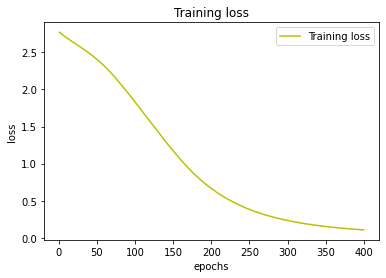

In [ ]:
#plotting 

loss = fitting_stage.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# spell checker and corrector


In [ ]:
"""

"""
from collections import Counter
def read_clean_subtitles(file):
  try:
    f = open(file, "r")
    subtitles= [line.strip() for line in f.readlines()]            
  except:
    print("File is not found or corrupted!")
    f.close()
   
  special_chars=r"^_`{|}~*+,-./:;<=>?@[\]!#$%&\"()"
  sent=""
        
  if len(subtitles)==0:
    raise Exception("File is empty! ")

  cleaned_txts=[] 
  #removing time-line and line-break from series/films
  no_timeL_lBreak =[line for line in subtitles if line!="" and line[0]!="0"]

                             
  #combining lines:
  #many sentences and/or uttarances are in two or more lines. This is why we need to combine then in lists for further processing when we work on phrases level not just words level.

  for line in no_timeL_lBreak:
    if  line[0].isdigit()==False:
      temp=re.sub(r"<i>","", re.sub(r"</i>","", line))  #remove  htm-tag <i>  </i>
      sent+= temp +" " 
    #when on digit, it means the speaker stop talking a little after finishing one uttrance
    elif line[0].isdigit() and sent!="": 
      temp= [char for char in sent if char not in special_chars]
      sent="".join(temp)
      sent=lemmatize(tokenize(sent))
      cleaned_txts.append(sent)
      sent=""
            
  return cleaned_txts



# frequency of the subtitles' vocubulary


subtitles=read_clean_subtitles("undertekster_test.txt")
#from 2-dim to one because count take 1-dim array
fatten = [w for sent in subtitles for w in sent]
frq=Counter(fatten)
frq_sorted=frq.most_common()

#make the matrix into two lists for forward processing in Class spell checker
candidate_wrds= [pair[0] for pair in frq_sorted]
their_freq= [pair[1] for pair in frq_sorted]

In [ ]:
from collections import Counter
import re


#spell checker and corrector for Norwegian
class spell_checker:
  def __init__(self,  user_inp):
    self.user_inp=user_inp   #alist of cleaned input
    self.dic=self.read_dic() # a list of the no. dic words
    self.misspelled_wrds=self.find_misspelled_ws()
    #subtit
    self.cleaned_txts=[]

    #Norwegian alphabet
    self.alphabet=["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "y", "æ", "ø", "å"]

  def read_dic(self):
    f=open("norsk_ordbok.txt","r", encoding='utf-8')
    dic=[]
    for line in f:
        l=line.split("/")
        dic.append(l[0])
    f.close()
    return dic

  def find_misspelled_ws(self):
    mis_ws=[]
    #return give a list of misspelled words in the inp
    for w in self.user_inp:
      if w.lower() not in self.dic and w !="-pron-":
        mis_ws.append(w.lower())
    return mis_ws




#...methods for generating strings................
  def insert(self,word):
    ar=[]
    chars=list(word)
    
    suggested_strs=[]
    for i,char in enumerate(chars): 
      for l in self.alphabet:
        if i==len(chars)-1:
          ar.append( word[:i+1] + l)
        else:
          ar.append( word[:i] +l+ word[i:])
    return ar


  def delete(self, word):

    generated_strs=[]
    chars=list(word)
    #if the nr. self.alphabet is 2 then no need to delete.
    if len(word)<=2:
      return []

    for i in range(len(chars)): 
        temp=word[:]        
        res_str = temp.replace(temp[i], '', 1)
        generated_strs.append(res_str)
        
    return generated_strs

  def replace(self, word):
    generated_strs=[]
    chars=list(word)  
    for i, char in enumerate(chars): 
      temp=chars[i]
      for  l in self.alphabet: 
        chars[i]=l
        replaced_w="".join(chars)
        generated_strs.append(replaced_w)
      chars[i]=temp
    return generated_strs


  def swap(self, word):
    generated_strs=[]
    chars=list(word) 
    if len(chars)>1:
      for i in range(len(chars)-1):
        temp=chars.copy()
        t=temp[i]
        temp[i]= temp[i+1]
        temp[i+1]= t
        generated_strs.append("".join(temp))
      return generated_strs



  def check_one(self, word):
    #the generated strs of all functions
    #given a misspelled word..generate strings that can be the target word
    gen_strs=self.insert(word), self.delete(word), self.replace(word),self.swap(word)
    concat_list=[]
    for lst in gen_strs:
      concat_list.extend(lst)
    return sorted(set(concat_list))

  
  def check_all(self):
    return [self.check_one(w) for w in self.misspelled_wrds]


  def wrds_frm_strs(self, strs):
    #identify  words from the generated strings 
    words=[]
    for w in strs:
      if w  in self.dic:
        words.append(w)  
    return words
    
  
  def auto_correct(self):
    selected_wrds=[] # the chosen words out of the candidate words (with highest freq in the subtitles)
    if len(self.misspelled_wrds)==0:
      #no misspelled words in the user input 
      return self.user_inp
    else:
      #matrix, every element is a list of genereted string og a misspeled word(from the user inp)
      gen_strings=self.check_all()
      
      extracted_wrds=[self.wrds_frm_strs(strs) for strs in gen_strings]

      for j,l in enumerate(extracted_wrds):
        if len(l)==1:
          selected_wrds.append(l[0])
          continue
        

        temp_freq=[]
        
        for w in l:
          

          if w not in candidate_wrds:
              temp_freq.append(1)

          else:
            i=candidate_wrds.index(w)
            
            temp_freq.append(their_freq[i])
        if len(temp_freq)==0:
          continue

        ii=temp_freq.index(max(temp_freq, default=0))
        
        #candidate_wrds.index(extracted_wrds[ii])
        
        selected_wrds.append(extracted_wrds[j][ii] )
    return selected_wrds
      


# main (Bag of Words)

In [26]:
def main():
  prev_inpTag=""

  while True:

    inp = input("You: ")
    
    if len(inp.split())>10:
      print("Bot: Maks antall ord er 10. Vær så snill, skriv mindre text.")
      continue
      
    elif inp.lower() == "q":
      print("Bot: Takk for praten! Chattes!")
      break
    
    
    tokenized_inp=tokenize(inp)
    lemmatized_inp=lemmatize(tokenized_inp)

    # .....spell check and auto completion...........
    sc=spell_checker(lemmatized_inp)
    mis_ws=sc.find_misspelled_ws()
    selected_ws=sc.auto_correct() #if no missepelled words, it returns the user inp

    if len(mis_ws) !=0 and len(selected_ws)!=0: #if there are imssed words and our spell checker a candidate to substitute
        #print("Bot: Obs. skrivefeil funnet! Ikke noe prob. Vi fikser der for deg!.")
        for w in mis_ws:
          i=lemmatized_inp.index(w)
          ii=mis_ws.index(w)
          print(lemmatized_inp)
          print(selected_ws)
          lemmatized_inp[i]=selected_ws[ii]


    pred_classes = nn.predict([bag_of_words(lemmatized_inp, uniq_words)])[0]
    i = np.argmax(pred_classes) #index of highest probabelity class
    print("   prob. of predicted class:", str(pred_classes[i])[:4],"%")
      

    if pred_classes[i]>0.4:
        pred_class=classes[i]  #highest prob. class
        responses = []
        for tg in obj["intents"]:
            if tg['tag'] == pred_class:
              responses = tg['responses']
          
        if prev_inpTag==pred_class:
          print("Bot: Jeg klarer ikke se forskjell på dette spørsmålet og ditt forrige spørsmål.")
          continue
        
        response = random.choice(responses)

        print("Bot: ", response)

        prev_inpTag=pred_class
        
    else:
        print("Bot: Jeg forstår ikke helt spørsmålet. Prøv gjerne igjen med andre ord.")
main()

   prob. of predicted class: 0.81 %
Bot:  Jeg bare gjøre jobben min!
   prob. of predicted class: 0.81 %
Bot: Jeg klarer ikke se forskjell på dette spørsmålet og ditt forrige spørsmål.
   prob. of predicted class: 0.92 %
Bot:  Hallo!
   prob. of predicted class: 0.81 %
Bot:  Vær så god!
   prob. of predicted class: 0.77 %
Bot:  God bedring!
   prob. of predicted class: 0.59 %
Bot:  Hyggelig!
   prob. of predicted class: 0.95 %
Bot:  Det var ikke best. Men nå er det bedre! :)
   prob. of predicted class: 0.95 %
Bot: Jeg klarer ikke se forskjell på dette spørsmålet og ditt forrige spørsmål.
   prob. of predicted class: 0.92 %
Bot:  Hallo!
   prob. of predicted class: 0.95 %
Bot:  ikke verst!
   prob. of predicted class: 0.92 %
Bot:  Hei! :)
   prob. of predicted class: 0.95 %
Bot:  Det var ikke best. Men nå er det bedre! :)
   prob. of predicted class: 0.88 %
Bot:  Du kan kalle me Chatto. Du da?
   prob. of predicted class: 0.88 %
Bot: Jeg klarer ikke se forskjell på dette spørsmålet og 

In [ ]:
s="hei på deg"
len(s.split())

# main (tf-idf, all steps)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


def tf_idf(data): 
 
  #param:a list of the tokenized patterns


  vec = TfidfVectorizer()
  vectors = vec.fit_transform(data)
  uniq_words = vec.get_feature_names_out()
  df = pd.DataFrame(vectors.todense(), columns=uniq_words)
  return df

"""

Then we read the praparing of traing data as we did in Bag of words with smaller differences. Then we do one hot-coding to represent our labels.
After that we build the network as we did earlier ib BOW


"""

#training data
cleaned_ptrns=[]
labels=[] #numerical rep. of the cleaned patterns

uniq_words=[] #or lemmas

for intent in obj["intents"]:

    for pattern in intent["patterns"]:
        cleaned_ptrn = lemmatize(tokenize(pattern)) 
        cleaned_ptrns.append(" ".join(cleaned_ptrn))
        labels.append(intent["tag"])
        

df = tf_idf(cleaned_ptrns)

#numerical representation of the training data
X = np.array(df)




In [ ]:
# one-hot coding



encoder = LabelEncoder()
int_encoded = encoder.fit_transform(labels)
#print(int_encoded)
int_encoded = int_encoded.reshape(len(int_encoded), 1)

### One hot encoding
onehot_obj = OneHotEncoder(sparse=False)
y = onehot_obj.fit_transform(int_encoded)

#to np array
y = np.array(y)
#print(y)
uniq_labels=sorted(list(set(labels)))

In [ ]:
#Network  architecture 


nn = tf.keras.models.Sequential()  #MLP/feedforward nn
nn.add( InputLayer(input_shape=[None, len(X[0])] ) )
nn.add(tf.keras.layers.Dense(12,activation='relu') )
#nn.add(tf.keras.layers.Dense(8,activation='relu') )

nn.add(tf.keras.layers.Dense(len(uniq_labels),activation='softmax'))  
nn.compile(loss='categorical_crossentropy',optimizer="adam", metrics=["accuracy"])
fitting_stage=nn.fit( X,y, epochs=400)

In [ ]:
loss = fitting_stage.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
prev_inpTag=""

while True:

  inp = input("You: ")

  if len(inp.split())>10:
    print("Bot: Maks antall ord er 10. Vær så snill, skriv mindre text.")
    
  elif inp.lower() == "q":
    print("Bot: Takk for praten! Chattes!")
    break
   
   
  
  cleaned=lemmatize(tokenize(inp))

  
  mapped=[0 for i in range( len(X[0]))]

  for i,wrd in enumerate(uniq_words):
   
    for wrd2 in cleaned:
      #print(wrd2)
      if wrd2==wrd:
        mapped[i]=1

  pred_classes = nn.predict([mapped])[0]
  i = np.argmax(pred_classes) #index of highest probabelity class
  print("prob. of predicted class: ",pred_classes[i])
    

  if pred_classes[i]>0.4:
      pred_class=uniq_labels[i]  #highest prob. class
      responses = []
      for tg in obj["intents"]:
          if tg['tag'] == pred_class:
            responses = tg['responses']
        
      if prev_inpTag==pred_class:
        print("Bot: Jeg klarer ikke se forskjell på dette spørsmålet og ditt forrige spørsmål.")
        continue
      
      response = random.choice(responses)

      print("Bot: ", response)

      prev_inpTag=pred_class
      
  else:
      print("Bot: Jeg forstår ikke helt spørsmålet. Prøv gjerne igjen med andre ord.")
